In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
%matplotlib inline

In [12]:
def load_labels(file_path):

    labels_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            key, value = line.split(':')  
            
            labels_dict[key] = value
    
    return labels_dict

In [13]:
def load_and_preprocess(img_pth, plot=True, transform=True):
    image = Image.open(str('panda.jpg'))
    if plot:
        plt.imshow(image)
        plt.show()
    
    if transform:
        transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0., std=1.)
        ])
    
    return transform(image).unsqueeze(0).to("cuda")


In [14]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.to("cuda")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def extract_conv_layers(model):
    conv_layers = []
    model_children = list(model.children())
    counter = 0

    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        conv_layers.append(child)
    
    return conv_layers

In [16]:
def get_activations(conv_layers, image):
    outputs = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
    
    return outputs


In [17]:
def summarize_channels(outputs):
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())

    return processed


In [18]:
def plot(processed_feaeture_maps):
    fig = plt.figure(figsize=(30, 20))
    for i in range(len(processed_feaeture_maps)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed_feaeture_maps[i])
        a.axis("off")


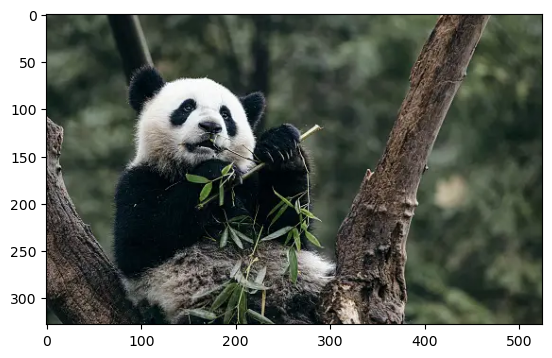

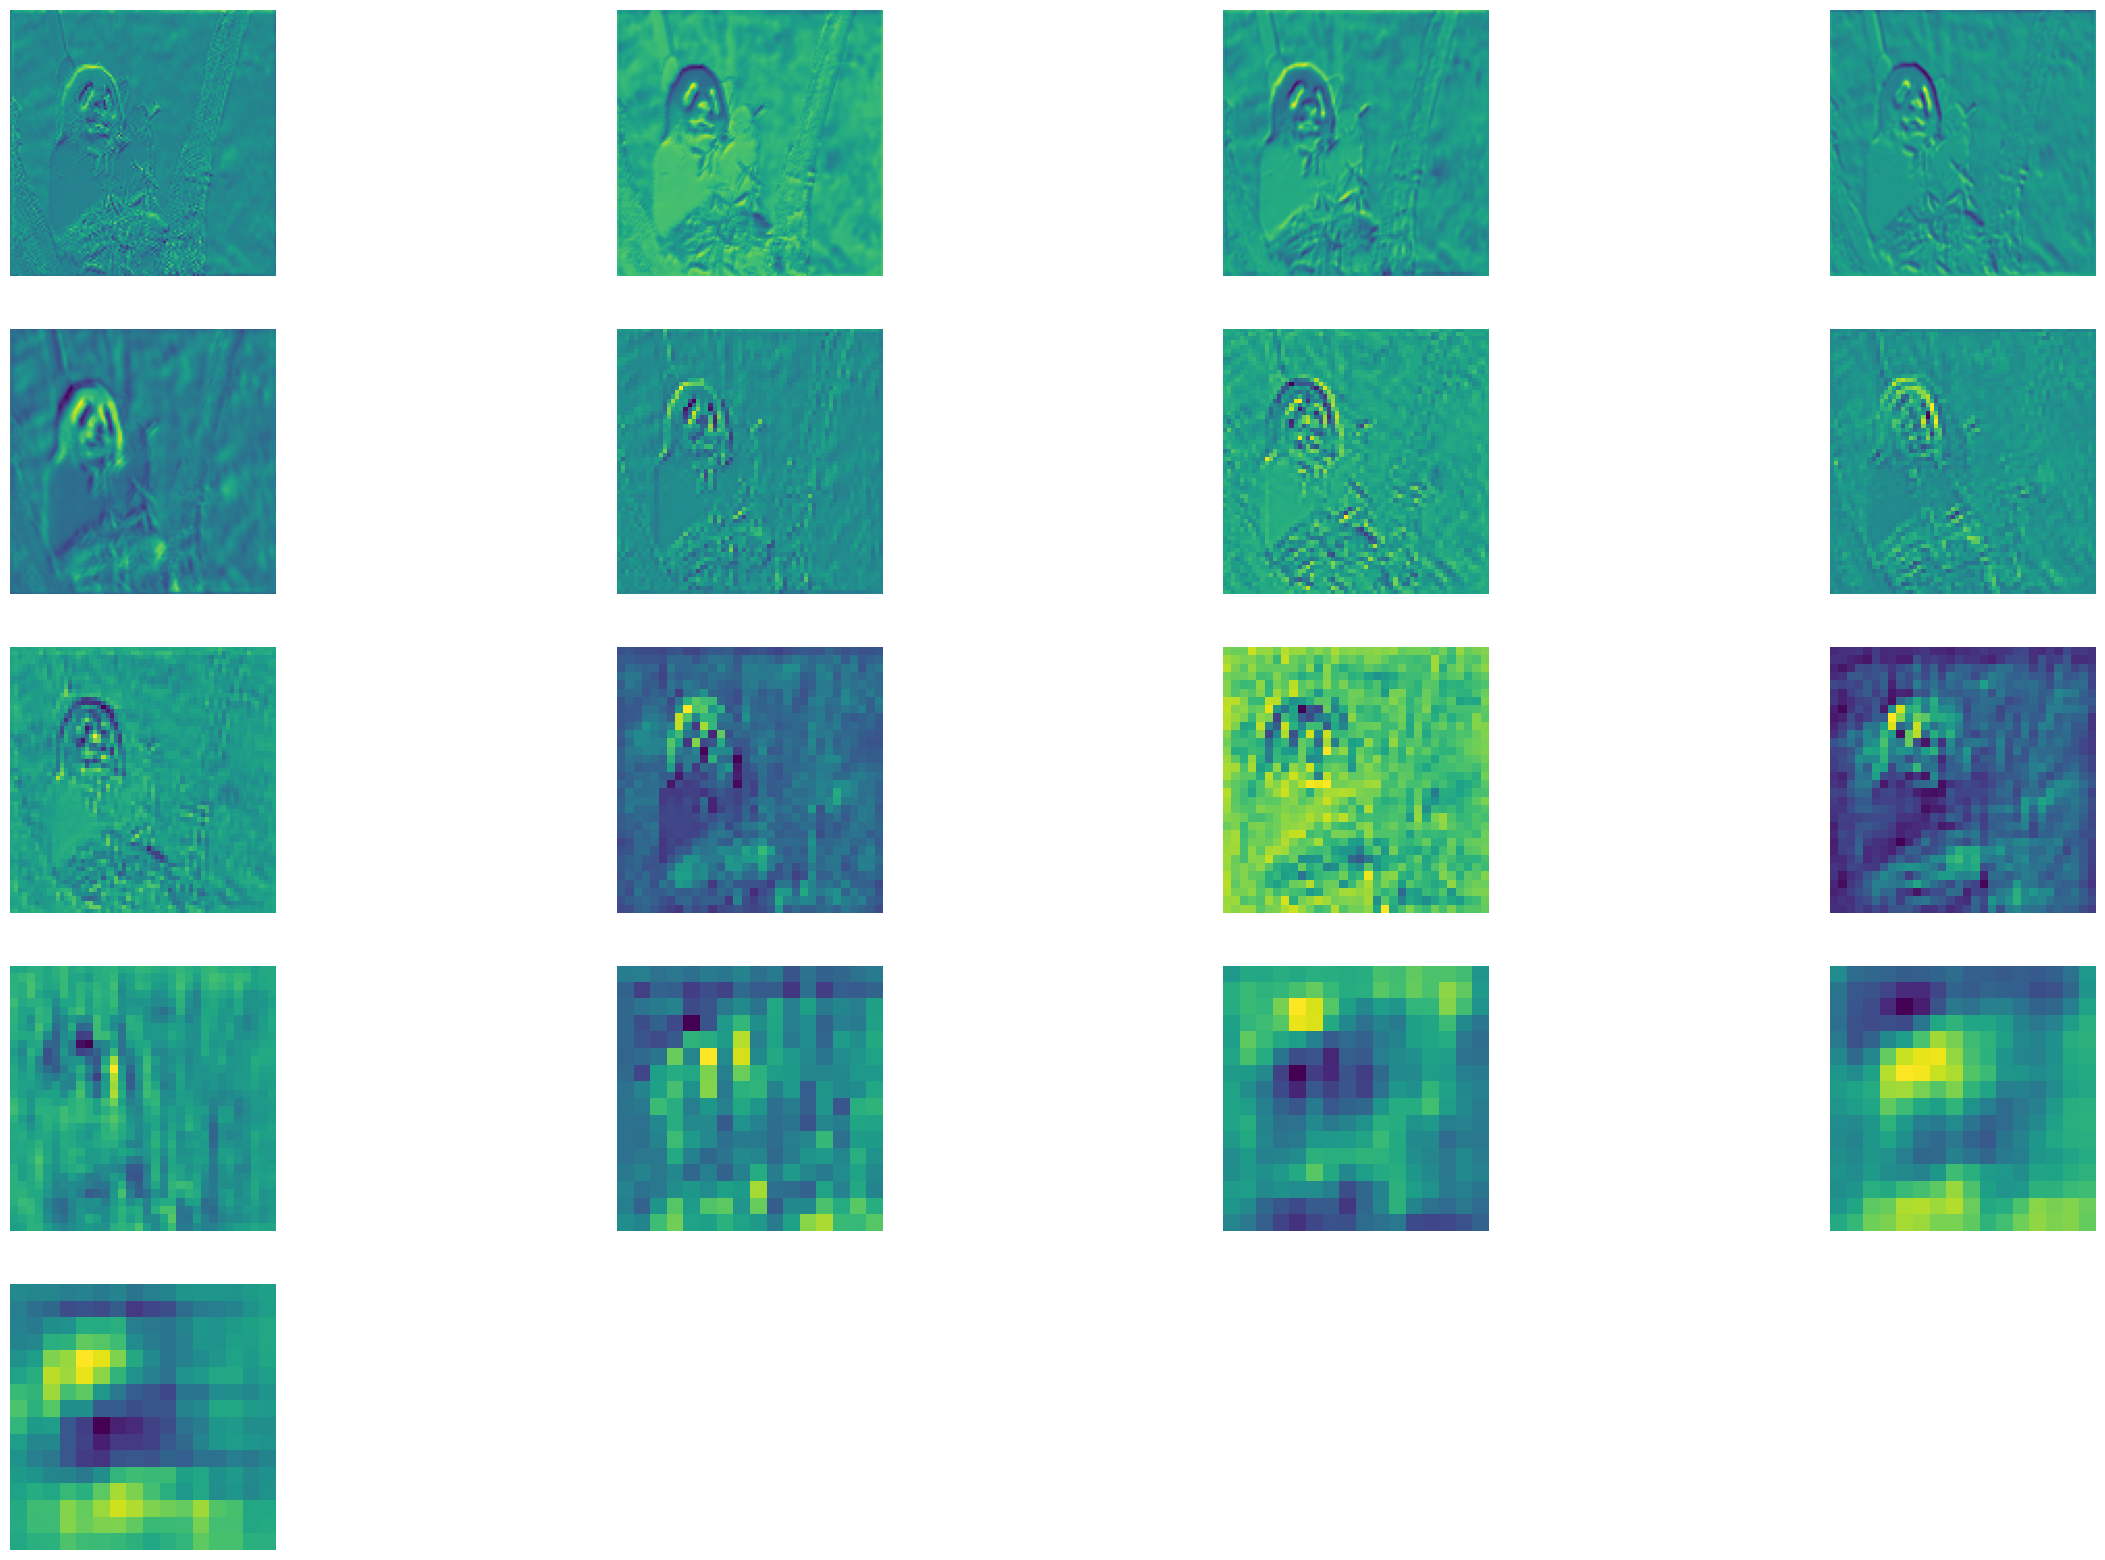

In [19]:
conv_layers = extract_conv_layers(model=model)
outputs  = get_activations(conv_layers=conv_layers, image=load_and_preprocess(img_pth='panda.jpg'))
processed_feature_maps = summarize_channels(outputs=outputs)
plot(processed_feature_maps)

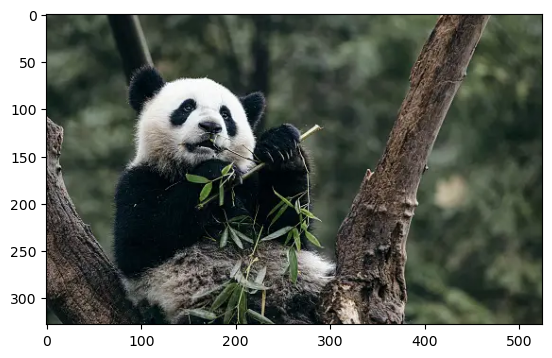

prediction is  'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',


In [20]:
image = load_and_preprocess(img_pth='panda.jpg')
ItoS = load_labels(file_path='labels.txt')
print(f"prediction is { ItoS[str(torch.argmax(model(image)).item())]}")